In [ ]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc as pm
import seaborn as sns ## for making nice plots, we used this in Week 3 at the end

## this is based on code from last week. To save time and typing, we can make it a function
def credible_interval_from_samples(samples, prob):
    """`samples` can be an nd array. Assume that all of the dimensions
    except for the last index parameters while the last (rightmost)
    dimension indexes the samples."""
    samples_sorted = sort(samples, axis=-1)
    N_samples = samples.shape[-1]
    index = int(N_samples*(1 - prob)/2)
    lower = samples_sorted[..., index]
    upper = samples_sorted[..., -index]
    return lower, upper

Populating the interactive namespace from numpy and matplotlib


# Example: divorce rate in the 50 United States

In [ ]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_to_data = 'drive/MyDrive/Colab Notebooks/MATH509/Data/'
data = pd.read_csv(path_to_data + 'WaffleDivorce.csv', sep=";", header=0)
data

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


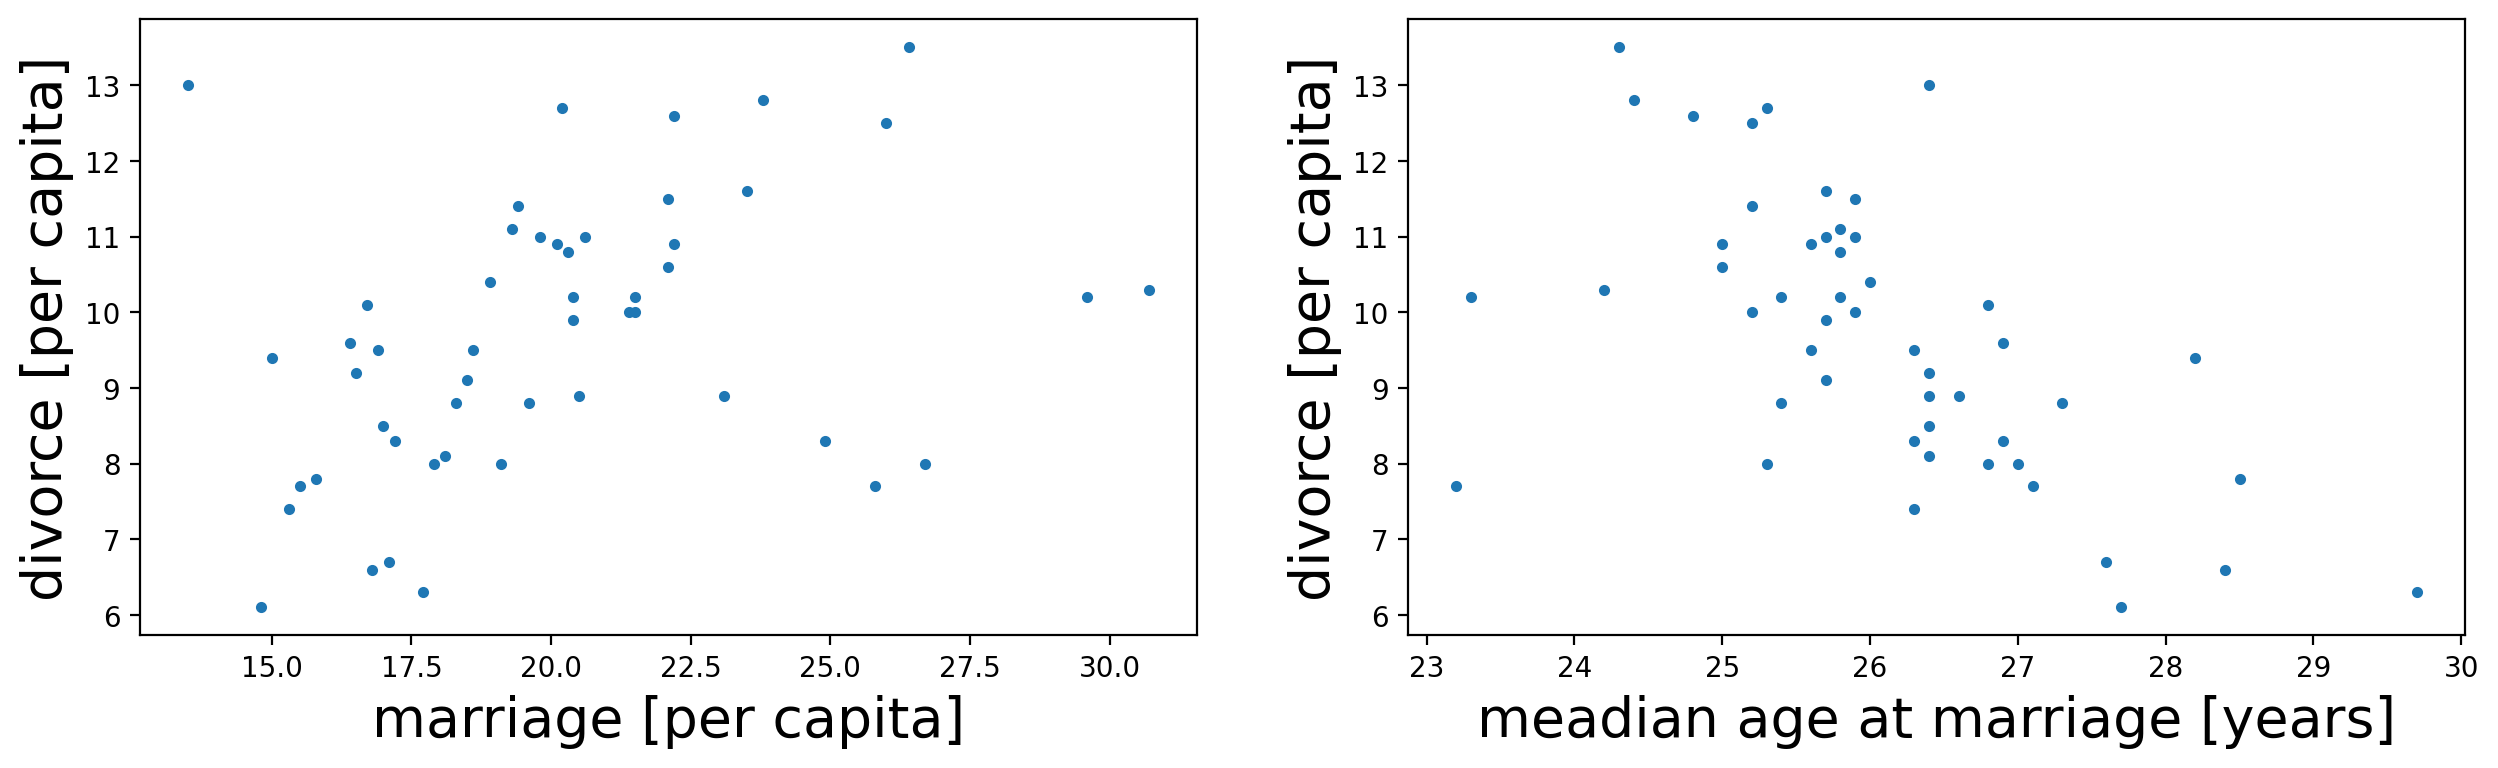

In [ ]:
fig = figure(1, [15, 4])

fig.add_subplot(121)
plot(data['Marriage'], data['Divorce'], '.')
xlabel('marriage [per capita]', fontsize=20)
ylabel('divorce [per capita]', fontsize=20)

fig.add_subplot(122)
plot(data['MedianAgeMarriage'], data['Divorce'], '.')
xlabel('meadian age at marriage [years]', fontsize=20)
ylabel('divorce [per capita]', fontsize=20);

## Standardize the data so that it has mean zero and unit standard deviation

In [ ]:
data_standardized = pd.read_csv(path_to_data + 'WaffleDivorce.csv', delimiter=";")
columns = ['MedianAgeMarriage', 'Marriage', 'Divorce']
data_standardized[columns] = (data[columns] - data[columns].mean())/data[columns].std()
data_standardized

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,-0.606290,0.022644,1.27,1.654205,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,-0.686699,1.549802,2.93,1.544364,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,-0.204241,0.048974,0.98,0.610716,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,-1.410387,1.655123,1.70,2.093569,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,0.599857,-0.266989,0.39,-0.927058,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,-0.284651,0.891544,1.24,1.050080,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,1.243135,-0.793595,1.06,-1.641024,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,0.439037,0.786223,2.89,-0.432773,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,2.931739,-0.635614,2.53,-1.860706,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,0.278218,-0.819926,0.58,-0.652455,0.32,133,1,61745,140424,0.440000


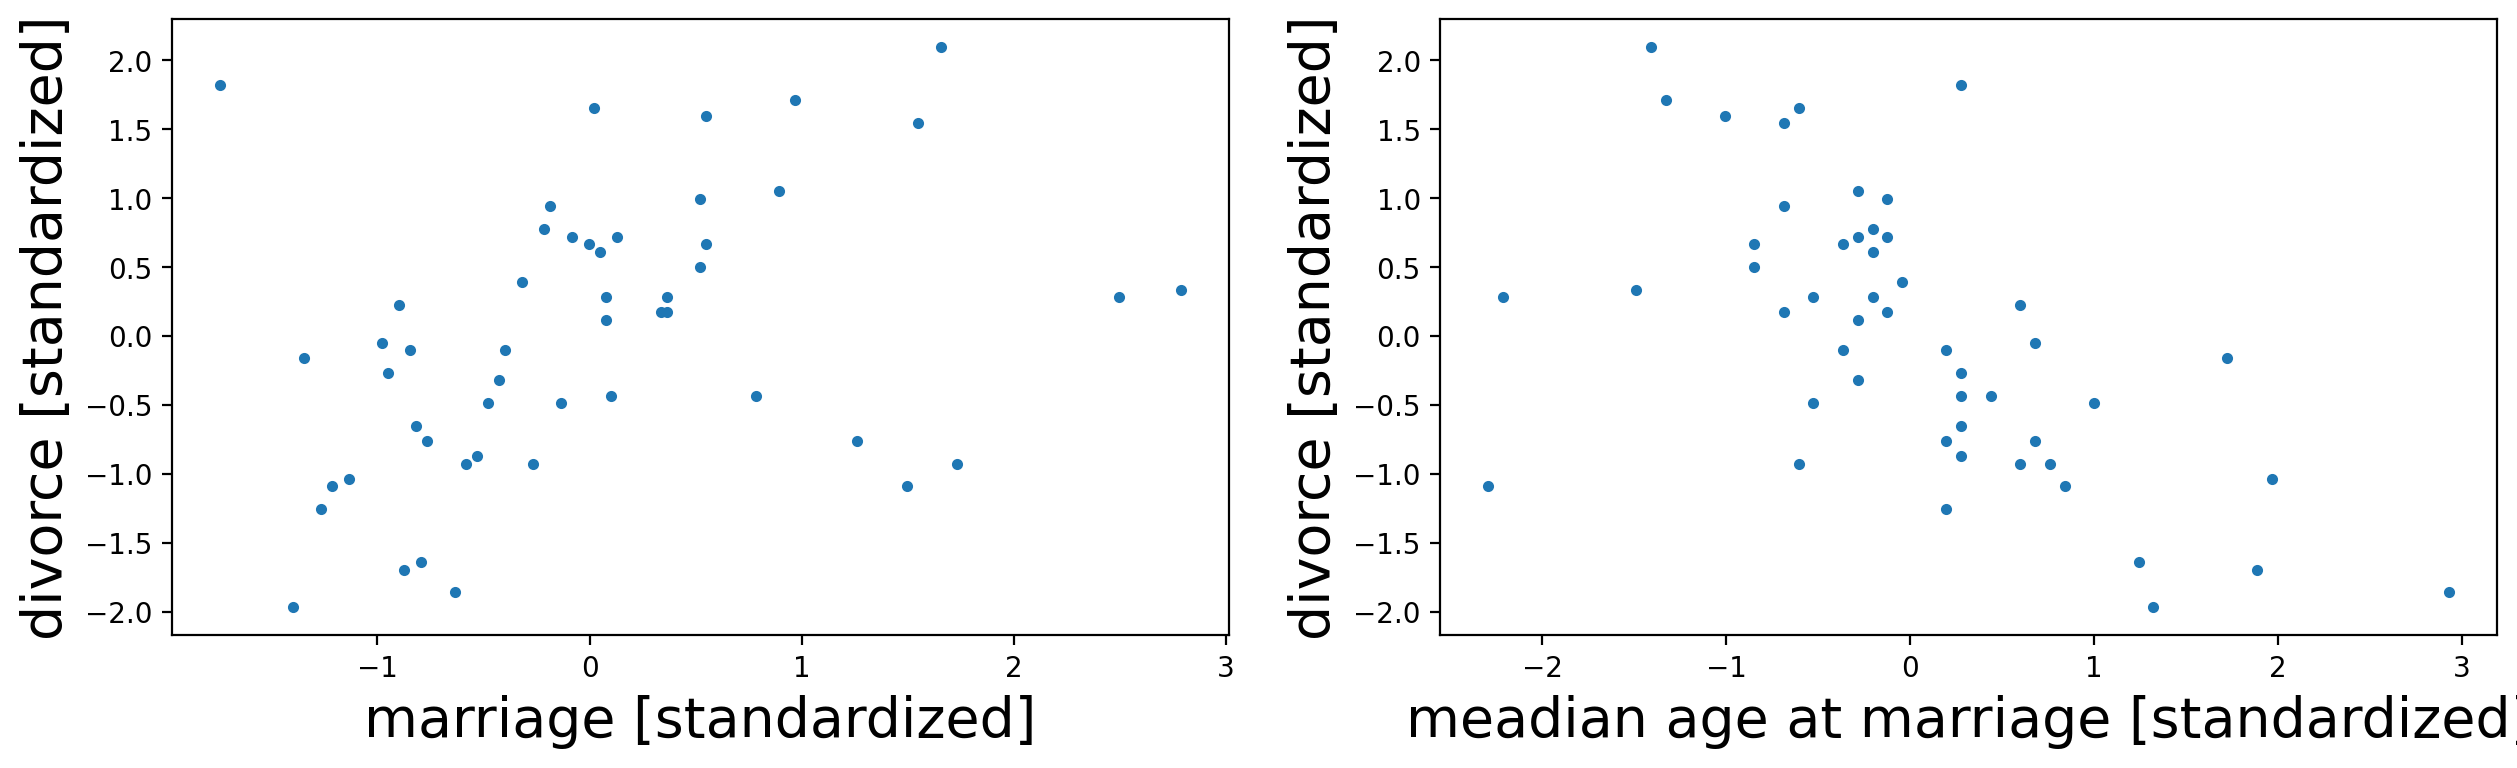

In [ ]:
fig = figure(1, [15, 4])

fig.add_subplot(121)
plot(data_standardized['Marriage'], data_standardized['Divorce'], '.')
xlabel('marriage [standardized]', fontsize=20)
ylabel('divorce [standardized]', fontsize=20)

fig.add_subplot(122)
plot(data_standardized['MedianAgeMarriage'], data_standardized['Divorce'], '.')
xlabel('meadian age at marriage [standardized]', fontsize=20)
ylabel('divorce [standardized]', fontsize=20);

The author suggests that merely comparing parameter means between bivariate regressions is no way to decide which predictor is better. They may be independent, or related or could eliminate each other. How do we understand all this?

He explains that here we may want to think **causally**.

A few interesting observations:
  1. Age has a direct impact on Divorce rate as people may grow incompatible with the parter
  2. Marriage Rate has a direct impact on Divorce rate for obvious reason (more marriages => more divorce)
  3. Finally, Age has an impact on Marriage Rate because there are more young people

Another way to represent above is:
  1. A -> D
  2. M -> D
  3. A -> M

and yet another way is to use DAG (Directed Acyclic Graphs)

# Multiple regression model
 \begin{align*}
    D_{i} &\sim \text{Normal}(\mu_i, \sigma) \\
    \mu_{i} &= \alpha + \beta_{M}M_{i} + \beta_{A}A_{i} \\
    \alpha &\sim \text{Normal}(0, 0.2) \\
    \beta_{M} &\sim \text{Normal}(0, 0.5) \\
    \beta_{A} &\sim \text{Normal}(0, 0.5) \\
    \sigma &\sim  \text{Exponential}(1)
  \end{align*}

In [ ]:
with pm.Model() as model_5_3:
    sigma = pm.Exponential('sigma', 1)
    beta_A = pm.Normal('beta_A', mu=0, sigma=0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=0.5)
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    ## Note that an underscore '_' is nothing special;
    ## it is just another character that can be part of a variable name.
    _mu = alpha + beta_M*data_standardized['Marriage'] + beta_A*data_standardized['MedianAgeMarriage']
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    D = pm.Normal('divorce', mu=mu, sigma=sigma, observed=data_standardized['Divorce'])
    _model_5_3_mcmc_samples = pm.sample(1000, tune=1000)
model_5_3_mcmc_samples = _model_5_3_mcmc_samples.posterior.to_dataframe()
model_5_3_mcmc_samples

beta_A    beta_M     alpha     sigma        mu
chain draw mu_dim_0                                                  
0     0    0        -0.466694 -0.154164 -0.090356  0.809236  0.189104
           1        -0.466694 -0.154164 -0.090356  0.809236 -0.008802
           2        -0.466694 -0.154164 -0.090356  0.809236 -0.002589
           3        -0.466694 -0.154164 -0.090356  0.809236  0.312702
           4        -0.466694 -0.154164 -0.090356  0.809236 -0.329146
...                       ...       ...       ...       ...       ...
1     999  45       -0.726382 -0.156444 -0.086865  0.894350 -0.304858
           46       -0.726382 -0.156444 -0.086865  0.894350 -0.049889
           47       -0.726382 -0.156444 -0.086865  0.894350  0.442831
           48       -0.726382 -0.156444 -0.086865  0.894350 -0.110515
           49       -0.726382 -0.156444 -0.086865  0.894350  0.559963

[100000 rows x 5 columns]

## Plot the posterior for $\beta_A$ and $\beta_M$ as a boxplot
The box shows the inter quartile range: 50% of the data around the median (horizontal black line).

<Axes: >

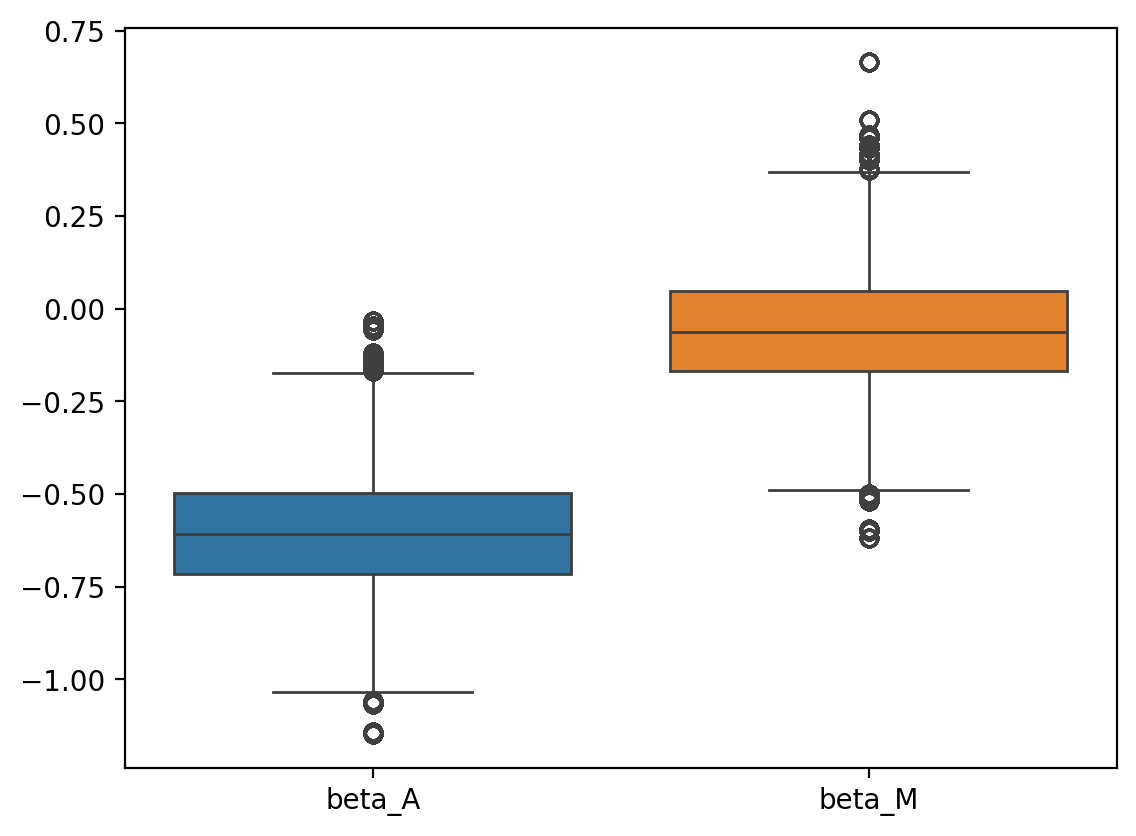

In [ ]:
sns.boxplot(data=model_5_3_mcmc_samples[['beta_A', 'beta_M']])

## Plot the posterior for $\beta_A$ and $\beta_M$ as violin plot
A boxplot has one flaw, it has a hard time characterizing a multi model posterior (multiple peaks). An alternative is to use a tiny probability density to represent the data. This is essentially using a KDE (see Week 3 and 4 notebooks) in each column. **Note that in this case the posterior appears to be unimodel (i.e., a single peak).**

<Axes: >

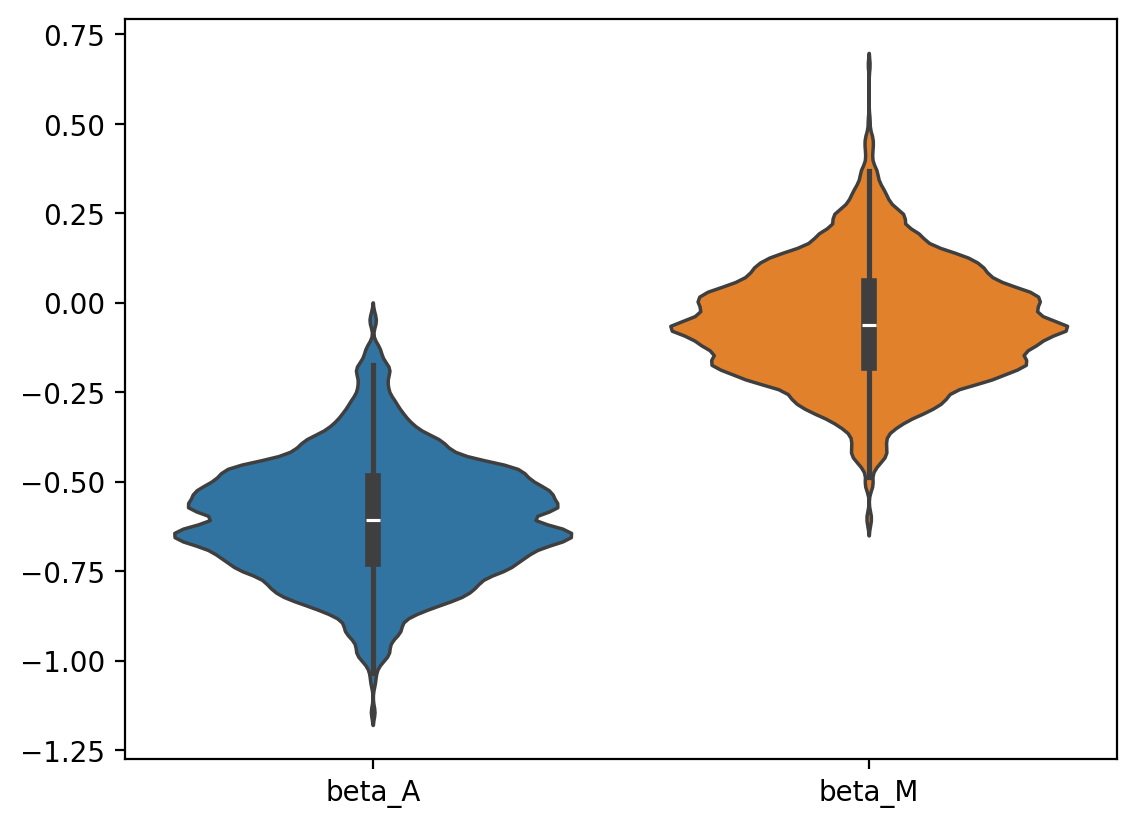

In [ ]:
sns.violinplot(data=model_5_3_mcmc_samples[['beta_A', 'beta_M']])

### Exercise: Compute a single variable regression for divorce rate vs marriage rate (see Week 4 notebook for examples). How does the parameter $\beta_M$ posterior distribution compare to the above from multiple regression?

## Posterior predictive plots
The PyMC3 package gives us a big shortcut for computing posterior predictive samples. (Compare this to our code from Week 4.)

In [ ]:
with model_5_3:
    posterior_predictive_samples = pm.sample_posterior_predictive(
        _model_5_3_mcmc_samples,
        var_names=["mu", "divorce"],
        # sample_dims=1000
        )['posterior_predictive']
posterior_predictive_samples.keys() ## the output is a Python dictionary

KeysView(<xarray.Dataset>
Dimensions:        (chain: 2, draw: 1000, mu_dim_2: 50, divorce_dim_2: 50)
Coordinates:
  * chain          (chain) int64 0 1
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * mu_dim_2       (mu_dim_2) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * divorce_dim_2  (divorce_dim_2) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Data variables:
    mu             (chain, draw, mu_dim_2) float64 0.1891 -0.008802 ... 0.56
    divorce        (chain, draw, divorce_dim_2) float64 0.6498 0.4562 ... 0.7264
Attributes:
    created_at:                 2024-01-23T19:11:46.147155
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.7.2)

In [ ]:
posterior_predictive_samples['divorce'].shape

(2, 1000, 50)

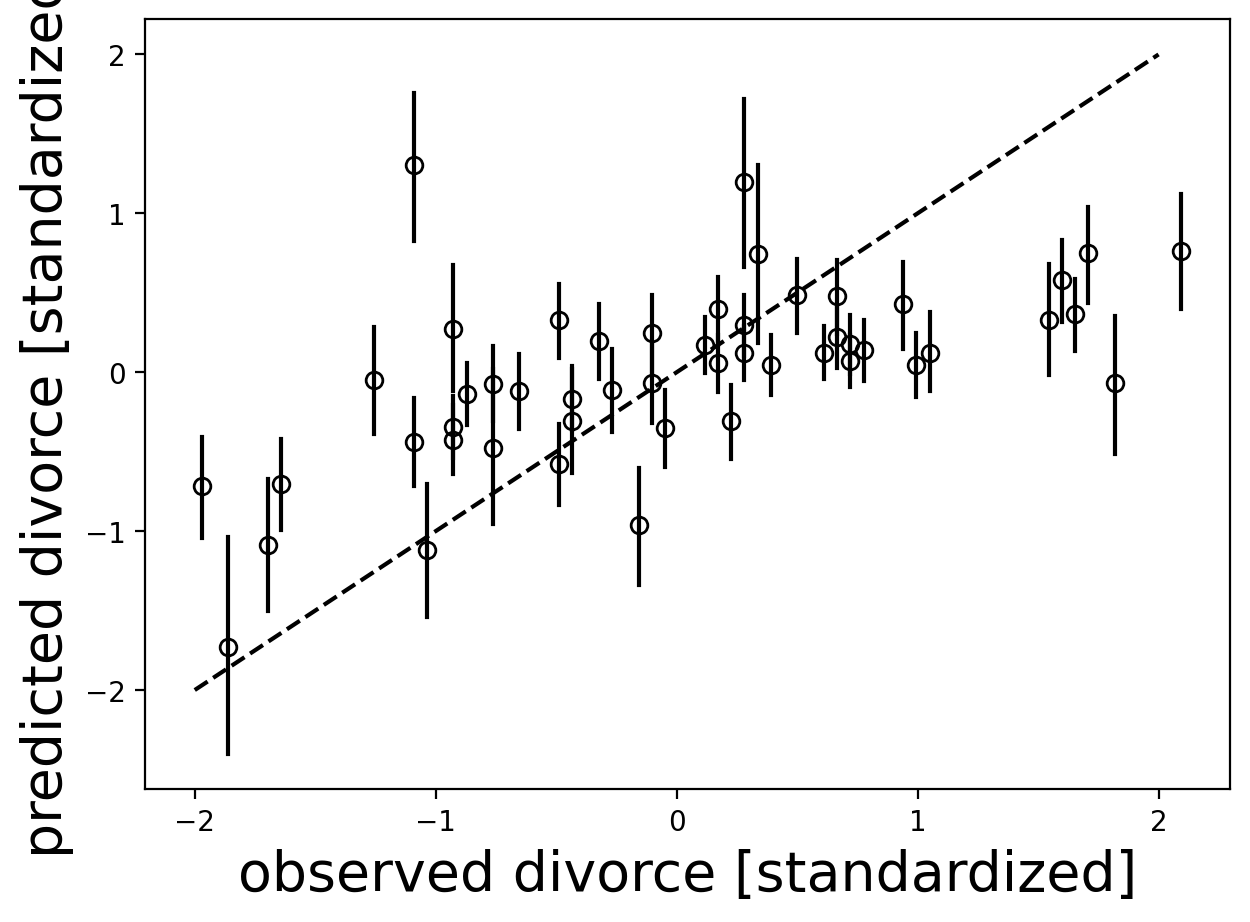

In [ ]:
mu_lower, mu_upper = credible_interval_from_samples(
    np.array(posterior_predictive_samples['mu']).transpose(2, 0, 1).reshape(50, -1),
    0.89)
mu_mean = posterior_predictive_samples['mu'].mean(axis=(0, 1))

figure(1, [7, 5])
plot(linspace(-2, 2), linspace(-2, 2), '--k')
plot(data_standardized['Divorce'], mu_mean, 'ko', mfc='none')
## plot a verticle line for each credible interval
cred_ints = array([mu_lower, mu_upper])
divorce_stacked = array(data_standardized['Divorce'])[None, :]*ones((2, 1))
plot(divorce_stacked, cred_ints, 'k')

ylabel('predicted divorce [standardized]', fontsize=20)
xlabel('observed divorce [standardized]', fontsize=20);

### Warning: the above plot might look like a linear regression (similar to last week) but it this is not the meaning. The dashed line indicates where the prediction exactly matches the observed divorce rate. This would be the same dashed line even if we used nonlinear regression.

# Counterfactual plots
The idea is to generate posterior prediction samples with specific values of an intervention variable. First, we will look at an example where the intervention variable is age.
  1. Generate parameter posterior samples of the combined model (includes effect of A -> M)
  2. Generate an array of values for intervention variable (e.g., for age)
  3. Use parameter posterior samples and manipulated ages to generate posterior prediction samples (of M and D)
  4. Plot the corresponding trends for M and D vs the intervention variable

In [ ]:
with pm.Model() as model_5_4:
    ## A -> M
    sigma_M = pm.Exponential('sigma_M', 1)
    beta_AM = pm.Normal('beta_AM', 0, 0.5)
    alpha_M = pm.Normal('alpha_M', 0, 0.2)
    mu_M = pm.Deterministic('mu_m', alpha_M + beta_AM*data_standardized["MedianAgeMarriage"])
    marriage = pm.Normal('marriage', mu_M, sigma_M, observed=data_standardized["Marriage"])

    ## A -> D <- M
    sigma = pm.Exponential('sigma', 1)
    beta_A = pm.Normal('beta_A', mu=0, sigma=0.5)
    beta_M = pm.Normal('beta_M', mu=0, sigma=0.5)
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    ## Note that an underscore '_' is nothing special;
    ## it is just another character that can be part of a variable name.
    _mu = alpha + beta_M*marriage + beta_A*data_standardized["MedianAgeMarriage"]
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    D = pm.Normal('divorce', mu=mu, sigma=sigma, observed=data_standardized['Divorce'])
    ## MCMC
    _model_5_4_mcmc_samples = pm.sample(1000, tune=1000)
model_5_4_mcmc_samples = _model_5_4_mcmc_samples.posterior.to_dataframe()
model_5_4_mcmc_samples

beta_AM   alpha_M    beta_A    beta_M  \
chain draw mu_m_dim_0 mu_dim_0                                           
0     0    0          0        -0.646735  0.102356 -0.751386 -0.094276   
                      1        -0.646735  0.102356 -0.751386 -0.094276   
                      2        -0.646735  0.102356 -0.751386 -0.094276   
                      3        -0.646735  0.102356 -0.751386 -0.094276   
                      4        -0.646735  0.102356 -0.751386 -0.094276   
...                                  ...       ...       ...       ...   
1     999  49         45       -0.765339  0.017108 -0.306428  0.116079   
                      46       -0.765339  0.017108 -0.306428  0.116079   
                      47       -0.765339  0.017108 -0.306428  0.116079   
                      48       -0.765339  0.017108 -0.306428  0.116079   
                      49       -0.765339  0.017108 -0.306428  0.116079   

                                   alpha   sigma_M     sigma      mu_m  \
chain draw mu_m_dim_0 mu_dim_0                                           
0     0    0          0         0.137350  0.691275  0.840460  0.494465   
                      1         0.137350  0.691275  0.840460  0.494465   
                      2         0.137350  0.691275  0.840460  0.494465   
                      3         0.137350  0.691275  0.840460  0.494465   
                      4         0.137350  0.691275  0.840460  0.494465   
...                                  ...       ...       ...       ...   
1     999  49         45       -0.196791  0.791735  0.958777  1.158073   
                      46       -0.196791  0.791735  0.958777  1.158073   
                      47       -0.196791  0.791735  0.958777  1.158073   
                      48       -0.196791  0.791735  0.958777  1.158073   
                      49       -0.196791  0.791735  0.958777  1.158073   

                                      mu  
chain draw mu_m_dim_0 mu_dim_0            
0     0    0          0         0.590773  
                      1         0.507217  
                      2         0.286197  
                      3         1.041056  
                      4        -0.288203  
...                                  ...  
1     999  49         45       -0.270247  
                      46       -0.119541  
                      47        0.126669  
                      48       -0.346469  
                      49        0.583581  

[5000000 rows x 9 columns]

### I didn't use the PyMC3 package to generate posterior prediction samples because I found it to be very confusing. It hides too many steps. We might use it in the future, but I think it helps to see the steps first.

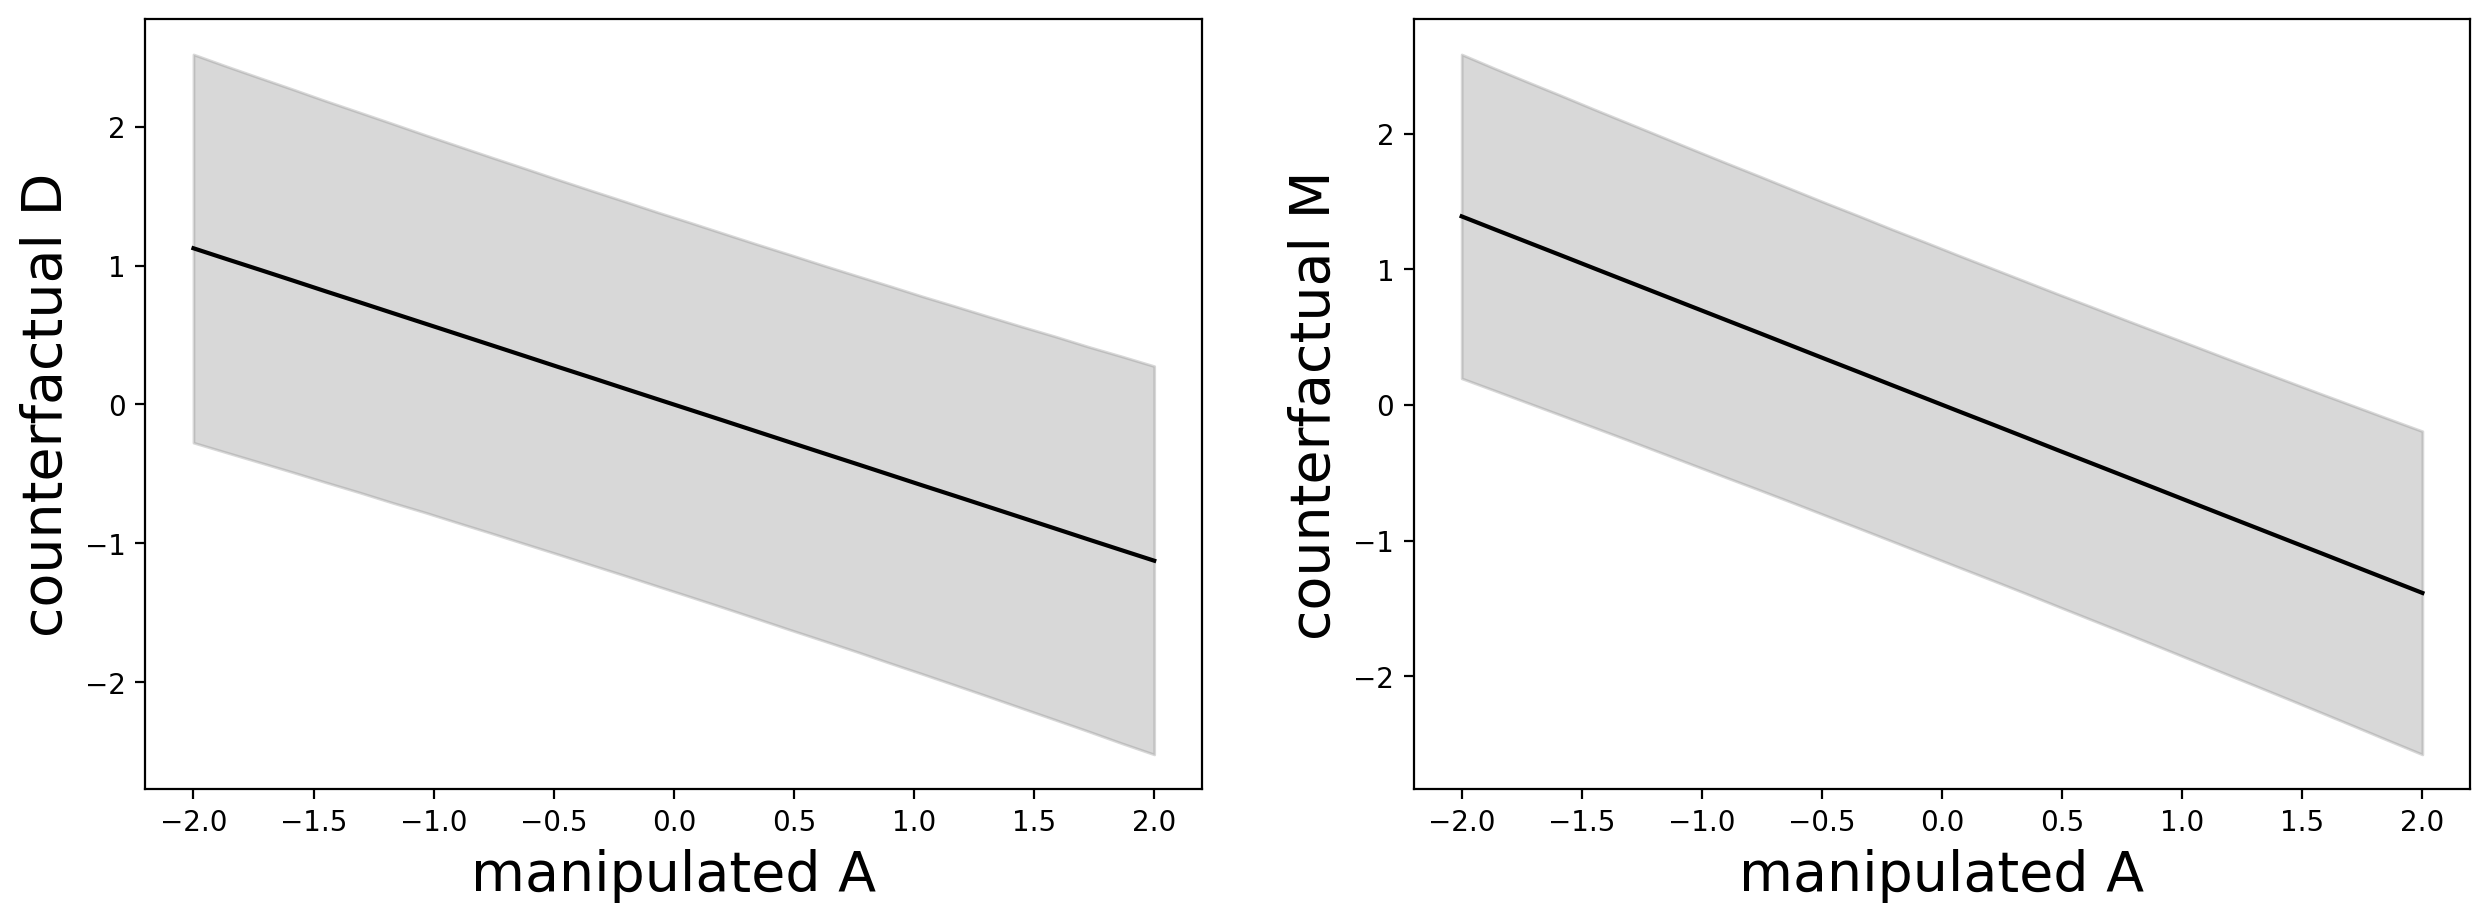

In [ ]:
N_cf = 30
N_posterior_samples = model_5_4_mcmc_samples.shape[0]
## intervention variable is Age
A_counter_factual = linspace(-2, 2, N_cf) ## the manipulated values for age

## first generate posterior predictive samples of M, using
## parameter posterior samples and intervention variable
alpha_M_post = array(model_5_4_mcmc_samples['alpha_M'])
beta_AM_post = array(model_5_4_mcmc_samples['beta_AM'])
sigma_M_post = array(model_5_4_mcmc_samples['sigma_M'])
mu_M = (alpha_M_post[None, :]
        + beta_AM_post[None, :]*A_counter_factual[:, None])
M = stats.norm.rvs(
    mu_M,
    sigma_M_post[None, :],
    size=(N_cf, N_posterior_samples))

## use above generated samples of M (along with parameter
## posterior samples) to generate samples of D
alpha_post = array(model_5_4_mcmc_samples['alpha'])
beta_A_post = array(model_5_4_mcmc_samples['beta_A'])
beta_M_post = array(model_5_4_mcmc_samples['beta_M'])
sigma_post = array(model_5_4_mcmc_samples['sigma'])
mu = (alpha_post[None, :]
      + beta_A_post[None, :]*A_counter_factual[:, None]
      + beta_M_post[None, :]*M)
D = stats.norm.rvs(
    mu,
    sigma_post[None, :],
    size=(N_cf, N_posterior_samples))


## Plot the result: credible intervals etc
prob = 0.89
M_lower, M_upper = credible_interval_from_samples(M, prob)
D_lower, D_upper = credible_interval_from_samples(D, prob)

fig = figure(1, [15, 5])

fig.add_subplot(121)
fill_between(A_counter_factual, D_upper, D_lower, color='0.5', alpha=0.3)
plot(A_counter_factual, D.mean(axis=1), 'k')
ylabel('counterfactual D', fontsize=20)
xlabel('manipulated A', fontsize=20);

fig.add_subplot(122)
fill_between(A_counter_factual, M_upper, M_lower, color='0.5', alpha=0.3)
plot(A_counter_factual, M.mean(axis=1), 'k')
ylabel('counterfactual M', fontsize=20)
xlabel('manipulated A', fontsize=20);

## Let's look at another example, this time we will use marriage as the intervention variable
Since we have no causal relationship of M -> A, and because A influences D, we will set $A=0$ for this example.

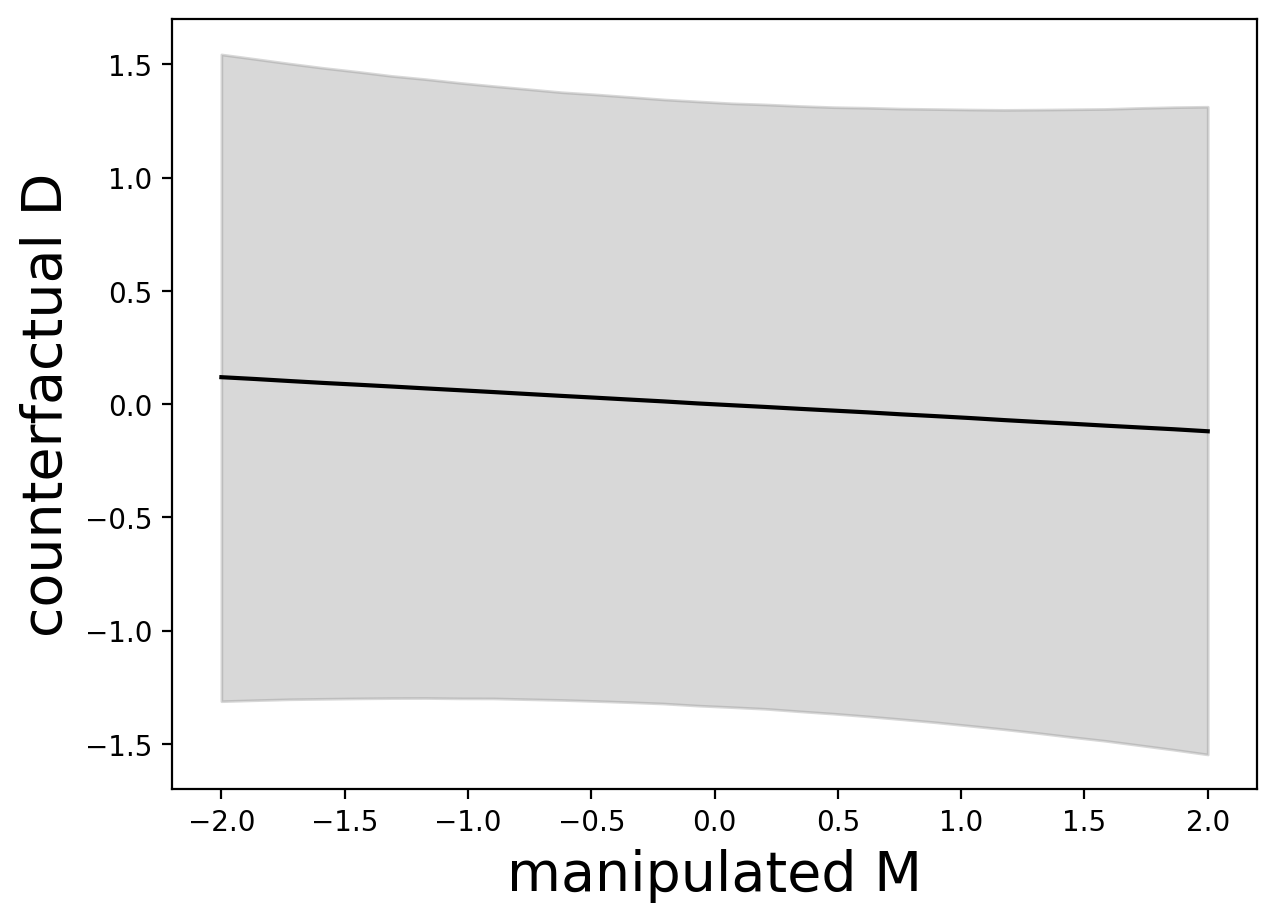

In [ ]:
N_cf = 30
N_posterior_samples = model_5_4_mcmc_samples.shape[0]
## intervention variable is Age
M_counter_factual = linspace(-2, 2, N_cf) ## the manipulated values for age
A = zeros(N_cf)

## use above generated samples of M (along with parameter
## posterior samples) to generate samples of D
alpha_post = array(model_5_4_mcmc_samples['alpha'])
beta_A_post = array(model_5_4_mcmc_samples['beta_A'])
beta_M_post = array(model_5_4_mcmc_samples['beta_M'])
sigma_post = array(model_5_4_mcmc_samples['sigma'])
mu = (alpha_post[None, :]
      + beta_A_post[None, :]*A[:, None]
      + beta_M_post[None, :]*M_counter_factual[:, None])
D = stats.norm.rvs(
    mu,
    sigma_post[None, :],
    size=(N_cf, N_posterior_samples))


## Plot the result: credible intervals etc
prob = 0.89
D_lower, D_upper = credible_interval_from_samples(D, prob)

figure(1, [7, 5])

fill_between(M_counter_factual, D_upper, D_lower, color='0.5', alpha=0.3)
plot(M_counter_factual, D.mean(axis=1), 'k')
ylabel('counterfactual D', fontsize=20)
xlabel('manipulated M', fontsize=20);

-----
# Next example: composition of milk across primate species, as well as some facts about those species, like body mass and brain size

In [ ]:
data_ex2 = pd.read_csv(path_to_data + 'milk.csv', delimiter=";")
data_ex2 = data_ex2[~isnan(data_ex2['neocortex.perc'])]
data_ex2['mass'] = log(data_ex2['mass'])
data_ex2

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,0.667829,55.16
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,1.658228,64.54
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,1.680828,64.54
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,0.920283,67.64
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,-0.385662,68.85
10,New World Monkey,Cebuella pygmaea,0.80,41.35,20.85,37.80,-2.120264,58.85
11,New World Monkey,Callimico goeldii,0.46,3.93,25.30,70.77,-0.755023,61.69
12,New World Monkey,Callithrix jacchus,0.71,38.38,20.09,41.53,-1.139434,60.32
15,Old World Monkey,Miopithecus talpoin,0.68,40.15,18.08,41.77,0.438255,69.97
17,Old World Monkey,M mulatta,0.97,55.51,13.17,31.32,1.175573,70.41


In [ ]:
columns = ['mass', 'neocortex.perc', 'kcal.per.g']
data_ex2_standardized = (data_ex2[columns] - data_ex2[columns].mean())/data_ex2[columns].std()
data_ex2_standardized

,mass,neocortex.perc,kcal.per.g
0,-0.430154,-2.080196,-0.969623
5,0.082211,-0.508641,-1.085298
6,0.093902,-0.508641,-0.564763
7,-0.299552,0.010742,1.343864
9,-0.975160,0.213470,1.517376
10,-1.872525,-1.461962,0.823329
11,-1.166241,-0.986139,-1.143135
12,-1.365110,-1.215673,0.302795
15,-0.548921,0.401118,0.129283
17,-0.167482,0.474837,1.806561


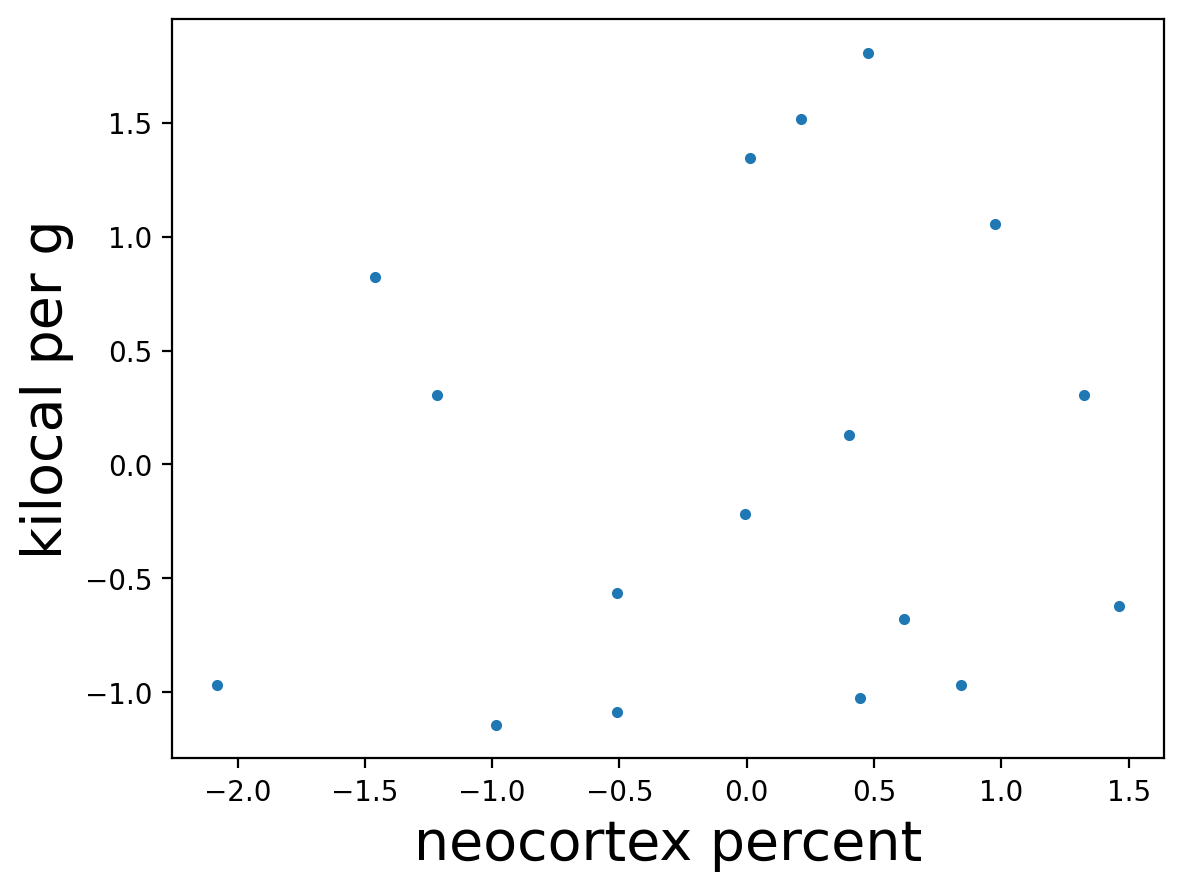

In [ ]:
plot(data_ex2_standardized['neocortex.perc'], data_ex2_standardized['kcal.per.g'], '.')
xlabel('neocortex percent', fontsize=20)
ylabel('kilocal per g', fontsize=20);

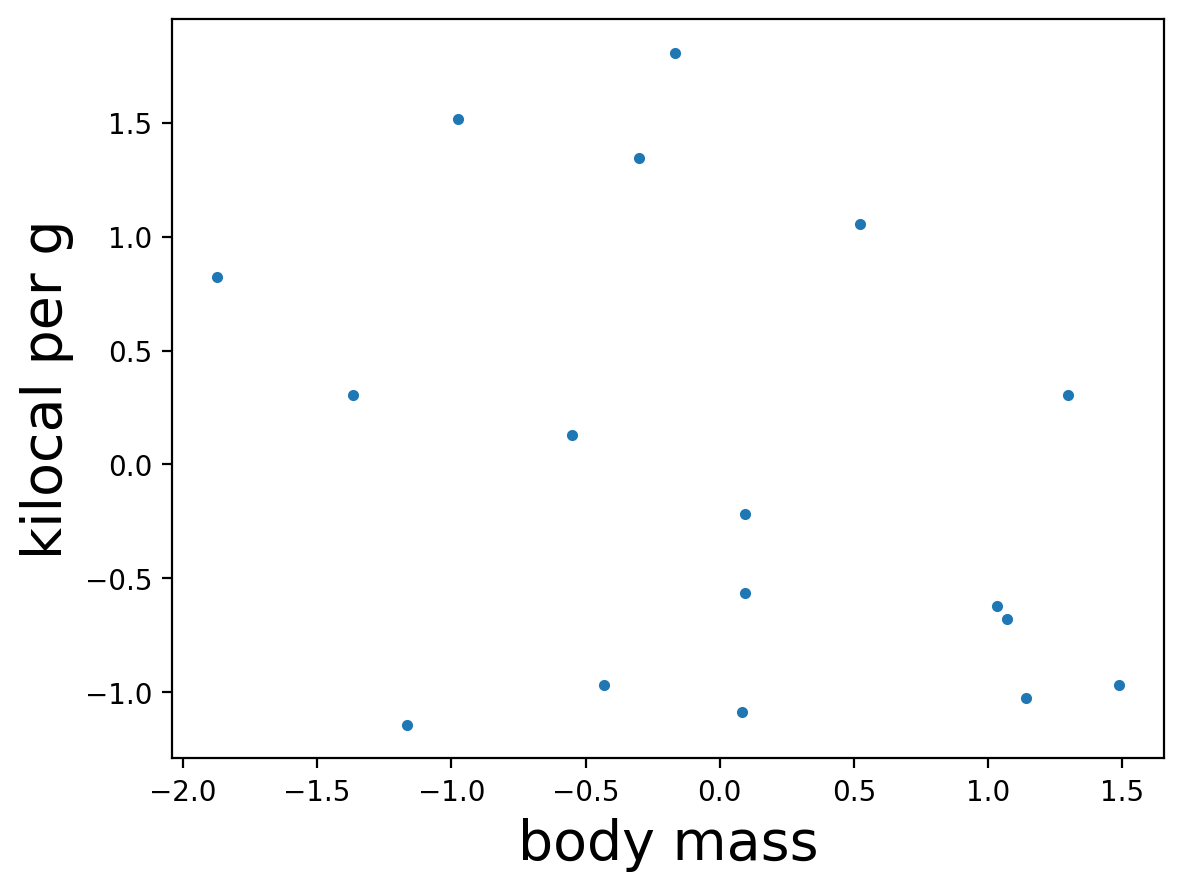

In [ ]:
plot(data_ex2_standardized['mass'], data_ex2_standardized['kcal.per.g'], '.')
xlabel('body mass', fontsize=20)
ylabel('kilocal per g', fontsize=20);

\begin{align}
K_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta_N N_i \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta_N &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align}

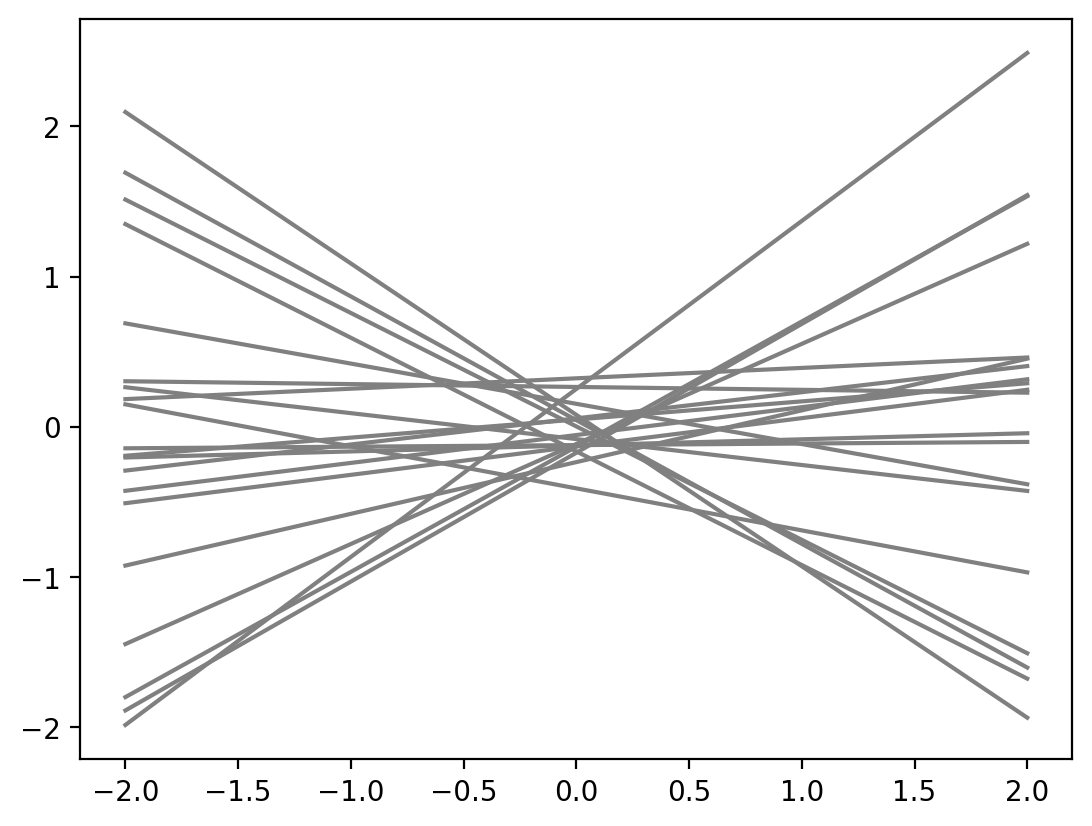

In [ ]:
## check priors
neo = linspace(-2, 2, 3)

alpha = normal(0, 0.2, 20)
beta_N = normal(0, 0.5, 20)

mu = alpha[None, :] + beta_N[None, :]*neo[:, None]
plot(neo, mu, '0.5');

In [ ]:
## model
with pm.Model() as model_KM:
    sigma = pm.Exponential('sigma', 1)
    beta_N = pm.Normal('beta_N', mu=0, sigma=0.5)
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    mu = alpha + beta_N*data_ex2_standardized['neocortex.perc']
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=data_ex2_standardized['kcal.per.g'])
    _posterior_KN = pm.sample(1000, tune=1000)
    posterior_KN = _posterior_KN.posterior.to_dataframe()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

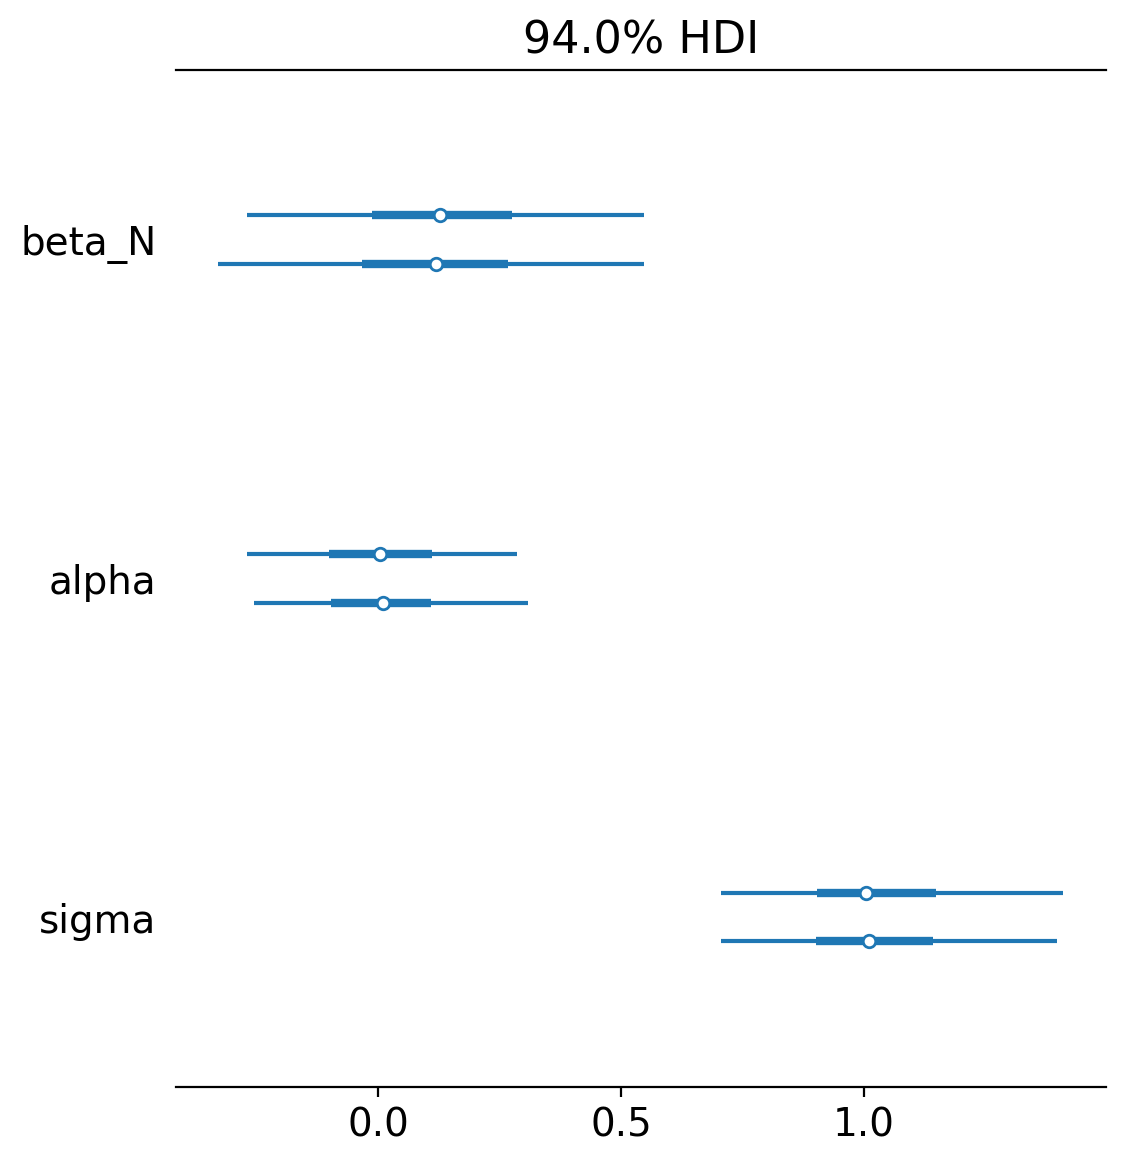

In [ ]:
import arviz as az ## This is new
az.plot_forest(_posterior_KN)

<ipython-input-52-a431bf59acf0>:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Kavg = alpha[None, :] + beta_N[None, :]*neo[:, None]
<ipython-input-52-a431bf59acf0>:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  K = normal(Kavg, sigma[None, :])


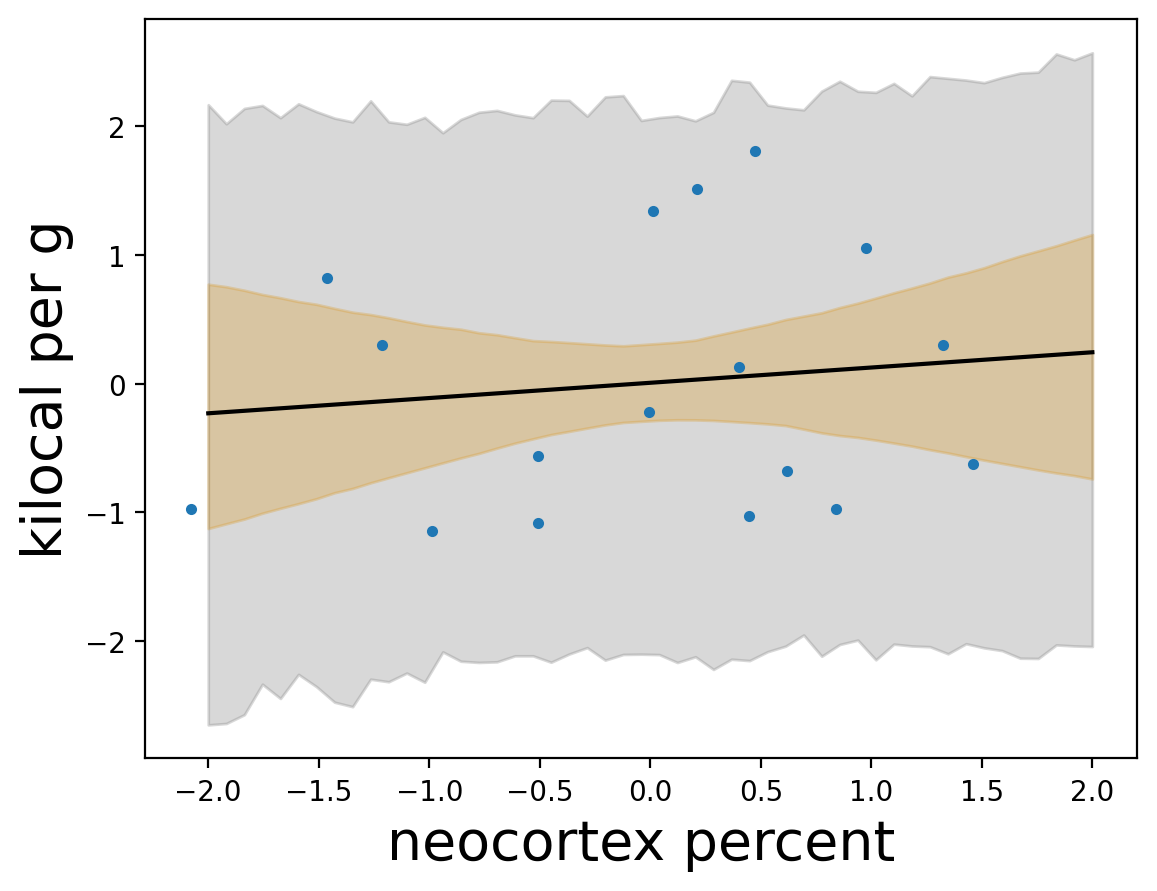

In [ ]:
## analysis plot



plot(data_ex2_standardized['neocortex.perc'], data_ex2_standardized['kcal.per.g'], '.')


neo = linspace(-2, 2, 50)

alpha = posterior_KN['alpha']
beta_N = posterior_KN['beta_N']
sigma = posterior_KN['sigma']

mu = alpha.mean() + beta_N.mean()*neo

Kavg = alpha[None, :] + beta_N[None, :]*neo[:, None]

prob = 0.95
Kavg_lower, Kavg_upper = credible_interval_from_samples(Kavg, prob)
fill_between(neo, Kavg_upper, Kavg_lower, color='orange', alpha=0.3)


K = normal(Kavg, sigma[None, :])

K_lower, K_upper = credible_interval_from_samples(K, prob)
fill_between(neo, K_upper, K_lower, color='0.5', alpha=0.3)

plot(neo, mu, 'k')


xlabel('neocortex percent', fontsize=20)
ylabel('kilocal per g', fontsize=20);

\begin{align}
K_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta_M M_i \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta_M &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align}

In [ ]:
## model
with pm.Model() as model_KM:
    sigma = pm.Exponential('sigma', 1)
    beta_M = pm.Normal('beta_M', mu=0, sigma=0.5)
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    mu = alpha + beta_M*data_ex2_standardized['mass']
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=data_ex2_standardized['kcal.per.g'])
    _posterior_KM = pm.sample(1000, tune=1000)
    posterior_KM = _posterior_KM.posterior.to_dataframe()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

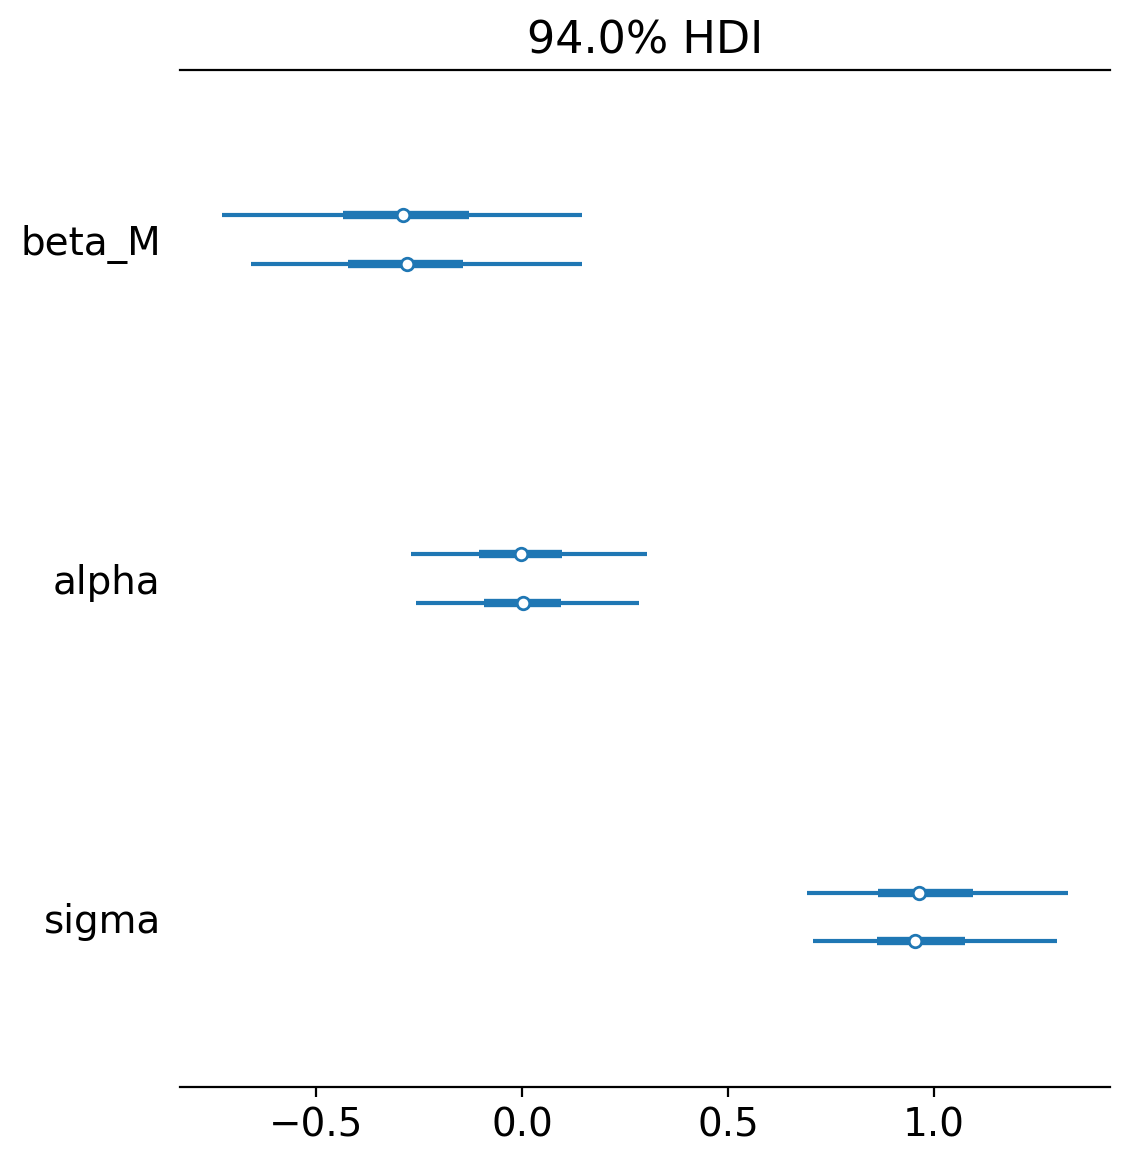

In [ ]:
az.plot_forest(_posterior_KM)

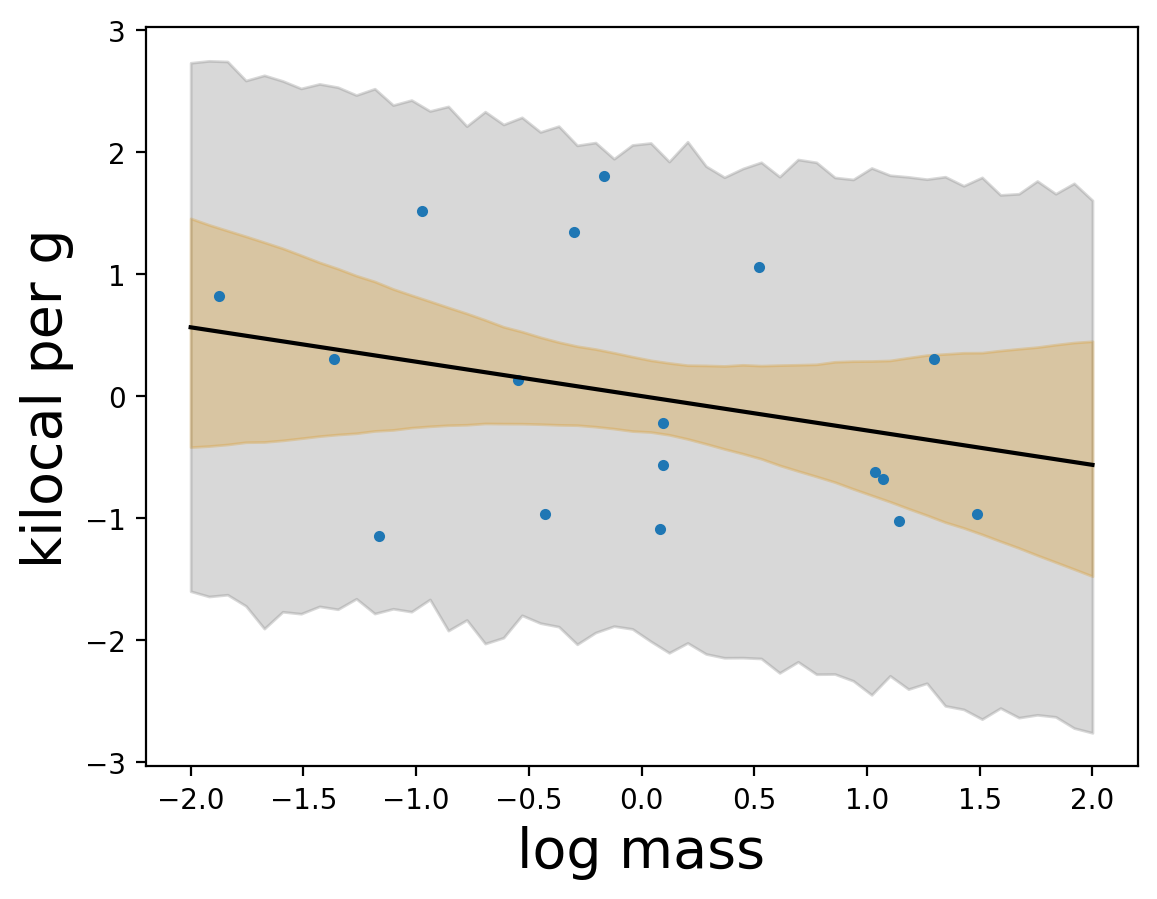

In [ ]:
## analysis plot
plot(data_ex2_standardized['mass'], data_ex2_standardized['kcal.per.g'], '.')


mass = linspace(-2, 2, 50)

alpha = array(posterior_KM['alpha'])
beta_M = array(posterior_KM['beta_M'])
sigma = array(posterior_KM['sigma'])

mu = alpha.mean() + beta_M.mean()*mass

Kavg = alpha[None, :] + beta_M[None, :]*mass[:, None]

prob = 0.95
Kavg_lower, Kavg_upper = credible_interval_from_samples(Kavg, prob)
fill_between(mass, Kavg_upper, Kavg_lower, color='orange', alpha=0.3)


K = normal(Kavg, sigma[None, :])

K_lower, K_upper = credible_interval_from_samples(K, prob)
fill_between(mass, K_upper, K_lower, color='0.5', alpha=0.3)

plot(mass, mu, 'k')


xlabel('log mass', fontsize=20)
ylabel('kilocal per g', fontsize=20);

\begin{align}
K_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta_N N_i + \beta_M M_i \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta_N &\sim \text{Normal}(0, 0.5) \\
\beta_M &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align}

In [ ]:
## model
with pm.Model() as model_KNM:
    sigma = pm.Exponential('sigma', 1)
    beta_M = pm.Normal('beta_M', mu=0, sigma=0.5)
    beta_N = pm.Normal('beta_N', mu=0, sigma=0.5)
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    mu = alpha + beta_M*data_ex2_standardized['mass'] + beta_N*data_ex2_standardized['neocortex.perc']
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=data_ex2_standardized['kcal.per.g'])
    _posterior_KNM = pm.sample(1000, tune=1000)
    posterior_KNM = _posterior_KNM.posterior.to_dataframe()
posterior_KNM

beta_M    beta_N     alpha     sigma
chain draw                                        
0     0    -0.715936  0.585072  0.071529  0.782342
      1    -0.876564  0.570081 -0.050687  0.641780
      2    -0.738097  0.768229  0.019833  0.645743
      3    -0.701099  0.398476  0.163655  0.941793
      4    -0.419843 -0.199891 -0.131486  1.276380
...              ...       ...       ...       ...
1     995  -0.856924  0.983241  0.214404  0.967467
      996  -0.716193  0.585574  0.365841  0.723016
      997  -0.838973  0.829728  0.232851  0.732767
      998  -0.860791  0.786028  0.100466  0.771637
      999  -0.942471  0.775840  0.131723  0.632470

[2000 rows x 4 columns]

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

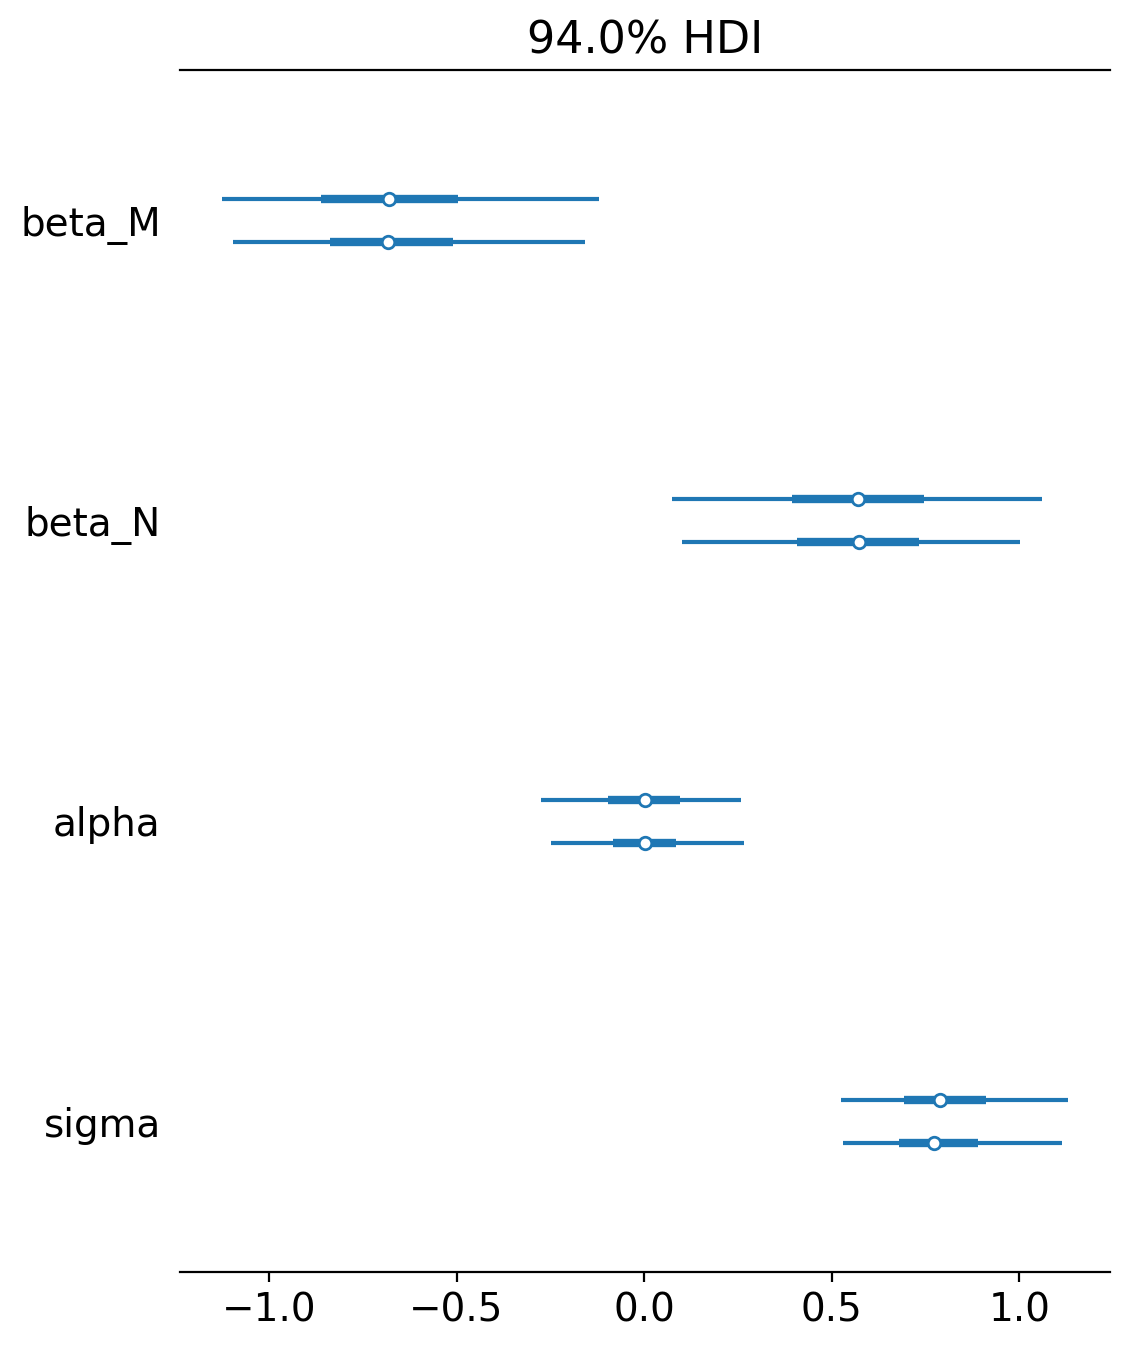

In [ ]:
az.plot_forest(_posterior_KNM)

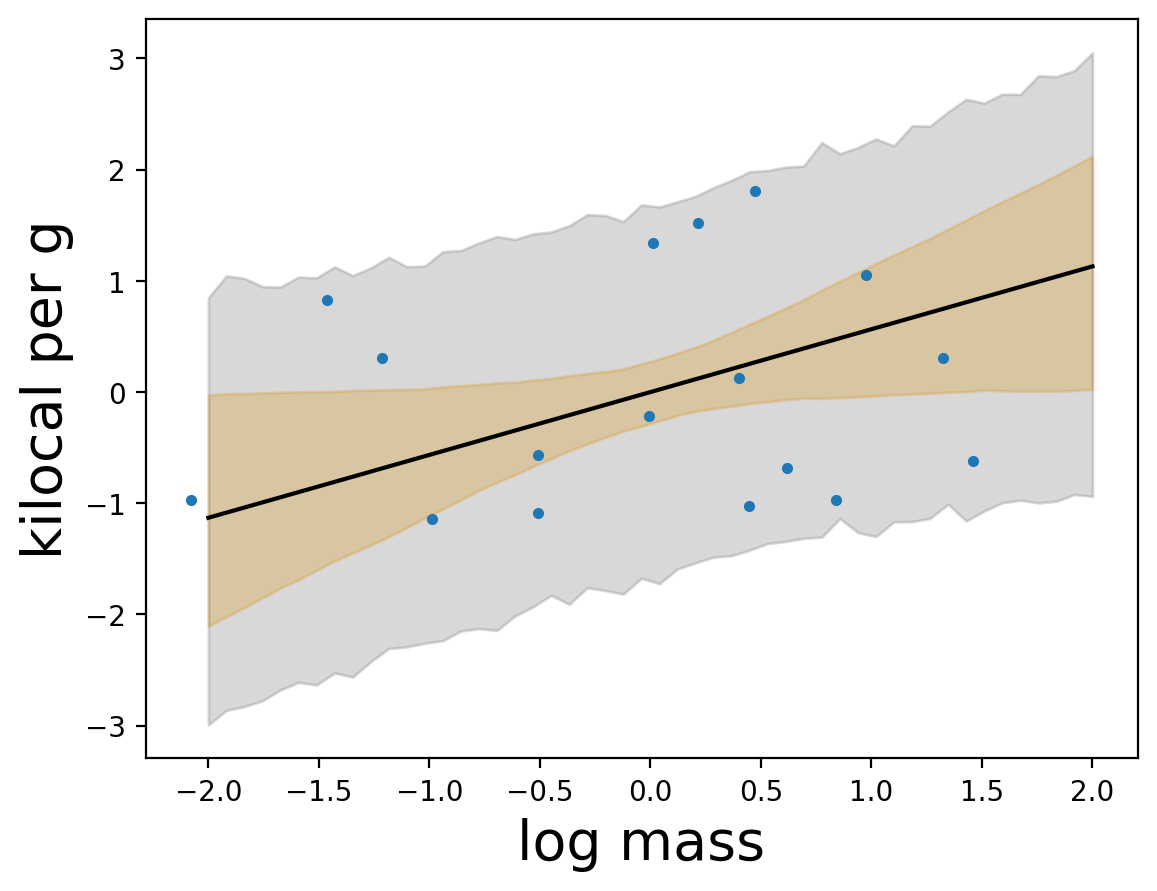

In [ ]:
## counterfactual analysis

## analysis plot
plot(data_ex2_standardized['neocortex.perc'], data_ex2_standardized['kcal.per.g'], '.')


neo = linspace(-2, 2, 50)
mass = array([0.])

alpha = array(posterior_KNM['alpha'])
beta_M = array(posterior_KNM['beta_M'])
beta_N = array(posterior_KNM['beta_N'])
sigma = array(posterior_KNM['sigma'])

mu = alpha.mean() + beta_M.mean()*mass + beta_N.mean()*neo

Kavg = alpha[None, :] + beta_M[None, :]*mass[:, None] + beta_N[None, :]*neo[:, None]

prob = 0.95
Kavg_lower, Kavg_upper = credible_interval_from_samples(Kavg, prob)
fill_between(neo, Kavg_upper, Kavg_lower, color='orange', alpha=0.3)


K = normal(Kavg, sigma[None, :])

K_lower, K_upper = credible_interval_from_samples(K, prob)
fill_between(neo, K_upper, K_lower, color='0.5', alpha=0.3)

plot(neo, mu, 'k')


xlabel('log mass', fontsize=20)
ylabel('kilocal per g', fontsize=20);


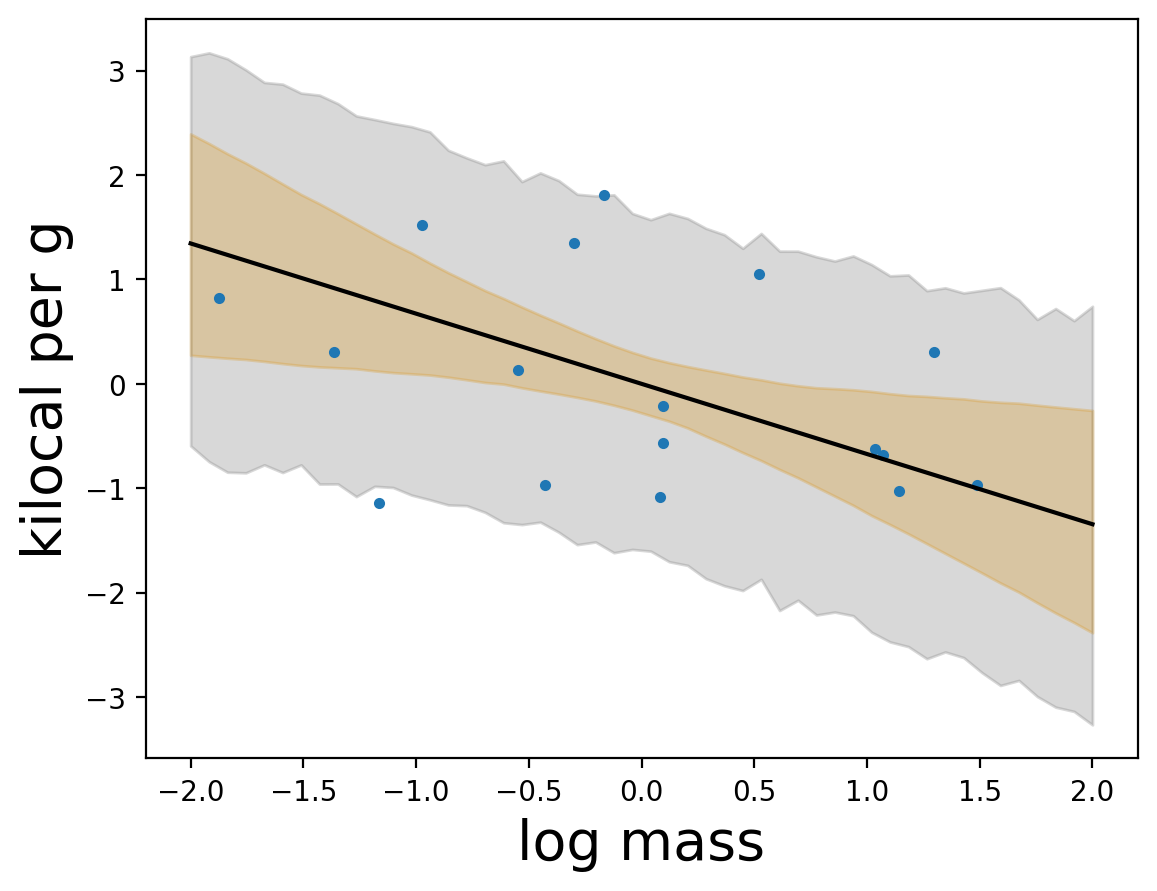

In [ ]:
## counterfactual analysis

## analysis plot
plot(data_ex2_standardized['mass'], data_ex2_standardized['kcal.per.g'], '.')


mass = linspace(-2, 2, 50)
neo = array([0.])

alpha = array(posterior_KNM['alpha'])
beta_M = array(posterior_KNM['beta_M'])
beta_N = array(posterior_KNM['beta_N'])
sigma = array(posterior_KNM['sigma'])

mu = alpha.mean() + beta_M.mean()*mass + beta_N.mean()*neo

Kavg = alpha[None, :] + beta_M[None, :]*mass[:, None] + beta_N[None, :]*neo[:, None]

prob = 0.95
Kavg_lower, Kavg_upper = credible_interval_from_samples(Kavg, prob)
fill_between(mass, Kavg_upper, Kavg_lower, color='orange', alpha=0.3)


K = normal(Kavg, sigma[None, :])

K_lower, K_upper = credible_interval_from_samples(K, prob)
fill_between(mass, K_upper, K_lower, color='0.5', alpha=0.3)

plot(mass, mu, 'k')


xlabel('log mass', fontsize=20)
ylabel('kilocal per g', fontsize=20);


## Effect of N on M
The cause of the masked effect: highly correlated predictor variables

In [ ]:
## model
with pm.Model() as model_NM:
    sigma = pm.Exponential('sigma', 1)
    beta_NM = pm.Normal('beta_NM', mu=0, sigma=0.5)
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    mu = alpha + beta_NM*data_ex2_standardized['neocortex.perc']
    M = pm.Normal('M', mu=mu, sigma=sigma, observed=data_ex2_standardized['mass'])
    _posterior_MN = pm.sample(1000, tune=1000)
    posterior_MN = _posterior_MN.posterior.to_dataframe()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

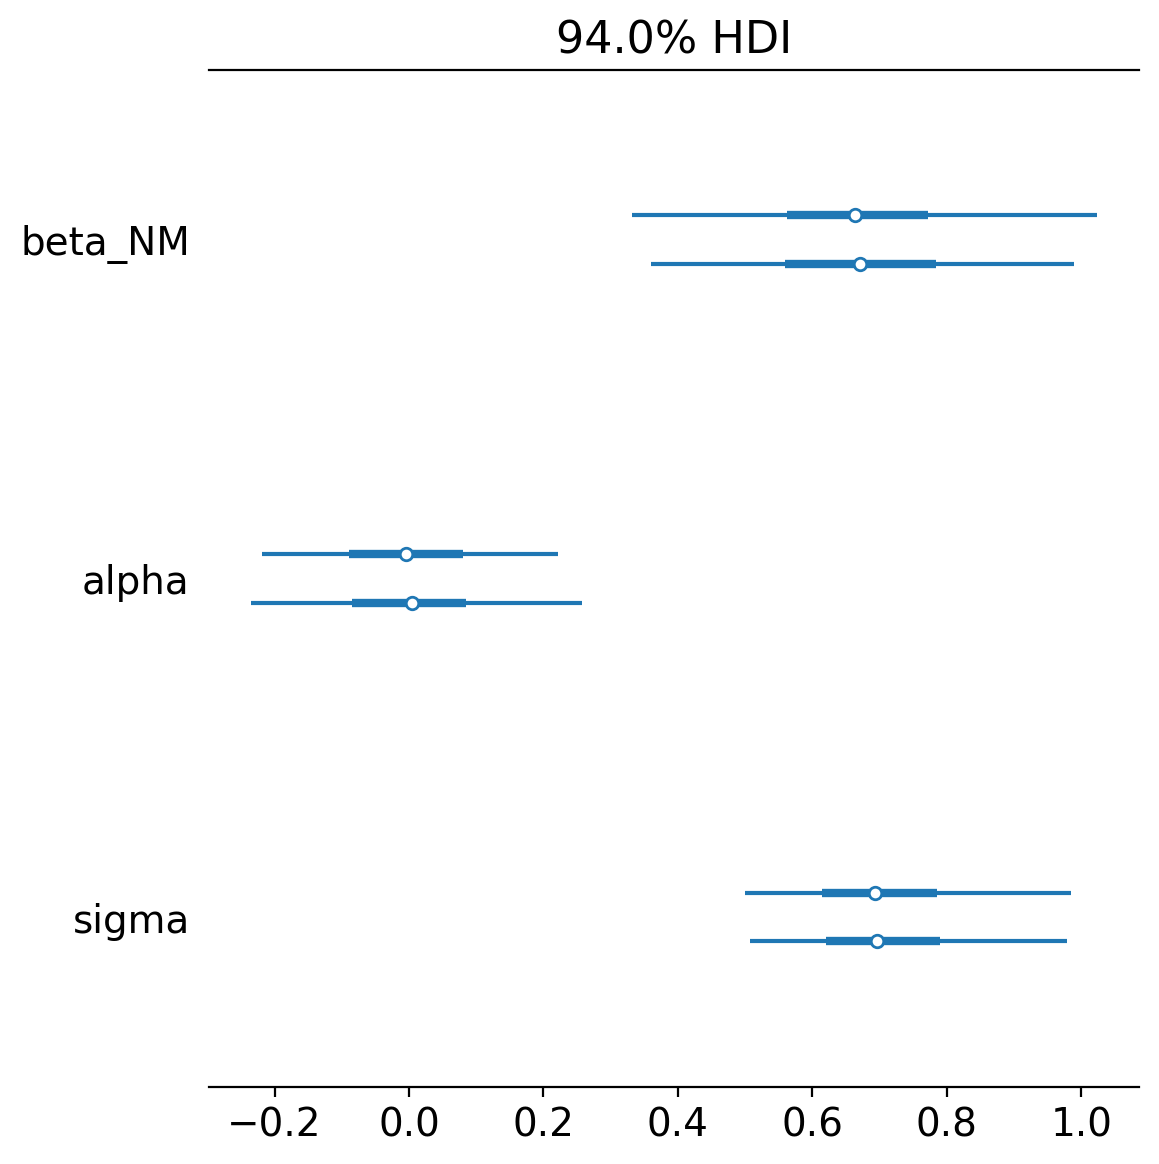

In [ ]:
az.plot_forest(_posterior_MN)

## Unlike the marriage example, there are no conditional independencies

In [1]:
!pip install git+https://github.com/BirkhoffG/causalgraphicalmodels.git

  Cloning https://github.com/BirkhoffG/causalgraphicalmodels.git to /tmp/pip-req-build-4a3v36h6
  Running command git clone --filter=blob:none --quiet https://github.com/BirkhoffG/causalgraphicalmodels.git /tmp/pip-req-build-4a3v36h6
  Resolved https://github.com/BirkhoffG/causalgraphicalmodels.git to commit cd178afc246160d1d0ec996a4ec0652cba580205
  Preparing metadata (setup.py) ... done
  Created wheel for causalgraphicalmodels: filename=causalgraphicalmodels-0.0.5-py3-none-any.whl size=10533 sha256=aff8105dd6a47a830d200185d5d869de358c43bc27b784e3531be84409237c7c
  Stored in directory: /tmp/pip-ephem-wheel-cache-chstr552/wheels/20/c2/cd/f747d458f9e2ddebdc0d90760b96441c2676e0b2f4e25cc33a
Successfully built causalgraphicalmodels


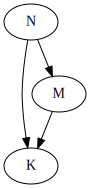

In [2]:
import causalgraphicalmodels as cgm
from causalgraphicalmodels import CausalGraphicalModel
CausalGraphicalModel(
    nodes=['M', 'N', 'K'], edges=[('N', 'M'), ('N', 'K'), ('M', 'K')]
).draw()